In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import shutil
import cv2
from ast import literal_eval

from sklearn.model_selection import train_test_split #KFold
%matplotlib inline

In [4]:
# FILES
RAWFILES = '/content/drive/MyDrive/tensorflow-great-barrier-reef'
TRAIN_IMGS = os.path.join(RAWFILES,'train_images')
TRAIN_CSV = os.path.join(RAWFILES,'train.csv')
TEST_CSV = os.path.join(RAWFILES,'test.csv')

In [5]:
# read the train and test csv
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

In [6]:
# CREATE WORKING DIRECTORY AFTER CLEANING

# define directories
# makes the working directory given the root dir and the subdir name

def make_dirs(workdirname):
    
    file_path = '/content/drive/MyDrive/'
    WORKDIRNAME = workdirname
    WORKDIR = os.path.join(file_path,WORKDIRNAME)
    DATA = os.path.join(WORKDIR,'DATA')
    TRAIN = os.path.join(DATA,'TRAIN')
    TEST = os.path.join(DATA,'TEST')
    VALID = os.path.join(DATA,'VALID')
    PRETRAINEDMODEL = os.path.join(DATA,'PRETRAINEDMODEL')

    if os.path.exists(file_path):
        if not os.path.exists(os.path.join(file_path,WORKDIRNAME)):
            os.mkdir(WORKDIR)
        if not os.path.exists(DATA):
            os.mkdir(DATA)
        if os.path.exists(DATA):
            if not os.path.exists(TRAIN):
                os.mkdir(TRAIN)  
            if not os.path.exists(TEST):
                os.mkdir(TEST)
            if not os.path.exists(VALID):
                os.mkdir(VALID)
            if not os.path.exists(PRETRAINEDMODEL):
                os.mkdir(PRETRAINEDMODEL)
    else:
        print("The file doesn't exist")
    return (WORKDIRNAME,WORKDIR,DATA,TRAIN,TEST,VALID,PRETRAINEDMODEL)

In [7]:
train_df.head(5)

,video_id,sequence,video_frame,sequence_frame,image_id,annotations
0,0,40258,0,0,0-0,[]
1,0,40258,1,1,0-1,[]
2,0,40258,2,2,0-2,[]
3,0,40258,3,3,0-3,[]
4,0,40258,4,4,0-4,[]


In [8]:
train_df['video_id'].value_counts()

2    8561
1    8232
0    6708
Name: video_id, dtype: int64

In [9]:
# extracts the bounding boxes of the starfish
def add_image_path(row,Train =True):
    
    #returns the image location
    video_id = row['video_id']
    image_id = row['image_id']

    filename = f"{TRAIN_IMGS}/video_{int(video_id)}/{image_id.split('-')[1]}.jpg"
    if(Train):
        annots = row['annotations']
        xmin = annots['x']
        xmax = annots['x'] + annots['width']
        ymin = annots['y']
        ymax = annots['y'] + annots['height']
        height = annots['height']
        width = annots['width']

        return [filename,xmin,xmax,ymin,ymax,height,width]
    else:
        return filename
 


In [10]:
# Extract the train images with annotations
train_data = train_df[train_df['annotations'] != '[]'] 
train_data.reset_index(inplace=True,drop=True)
# make a copy of the test_dummy
test_data = test_df.copy()


# extract 20 images for inferences
test_images_csv = train_data.iloc[-10:]
test_images_csv['filename'] = test_images_csv.apply(lambda row: add_image_path(row,Train =False),axis =1)
# drop the last 20 rows from train data
drop_data = train_data.copy()

train_data = drop_data.drop(list(test_images_csv.index))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4909 entries, 0 to 4908
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   video_id        4909 non-null   int64 
 1   sequence        4909 non-null   int64 
 2   video_frame     4909 non-null   int64 
 3   sequence_frame  4909 non-null   int64 
 4   image_id        4909 non-null   object
 5   annotations     4909 non-null   object
dtypes: int64(4), object(2)
memory usage: 268.5+ KB


## **YOLO 5 Pretrained Model**

In [12]:
# make workdir for the YOLO
WORKDIRNAME,WORKDIR,DATA,TRAIN,TEST,VALID,PRETRAINEDMODEL = make_dirs(workdirname='YOLOV5')

In [13]:
# copy test images to test folder
for test_image in list(test_images_csv['filename']):
    shutil.copy(test_image,TEST)

In [14]:
# download yolo5 weights and pretrained model
#Download W&B to monitor training

os.chdir(WORKDIR)

!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt

fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/drive/MyDrive/YOLOV5/yolov5
     |████████████████████████████████| 596 kB 34.6 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [15]:
os.chdir(DATA)

In [16]:
#create data.yaml
os.chdir(DATA)

'''
train: /content/drive/MyDrive/YOLOV5/DATA/TRAIN/images 
val: /content/drive/MyDrive/YOLOV5/DATA/VALID/images
nc: 1
names: ['starfish']
'''

!echo "train: /content/drive/MyDrive/YOLOV5/DATA/TRAIN/images" > data.yaml
!echo "val: /content/drive/MyDrive/YOLOV5/DATA/VALID/images">> data.yaml
!echo "nc: 1">> data.yaml
!echo "names: ['starfish']">> data.yaml


In [17]:
# create labels and image folders in  the train and test folders
!mkdir \
'/content/drive/MyDrive/YOLOV5/DATA/TRAIN/images' \
    '/content/drive/MyDrive/YOLOV5/DATA/TRAIN/labels' \
        '/content/drive/MyDrive/YOLOV5/DATA/VALID/labels' \
            '/content/drive/MyDrive/YOLOV5/DATA/VALID/images'

mkdir: cannot create directory ‘/content/drive/MyDrive/YOLOV5/DATA/TRAIN/images’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/YOLOV5/DATA/TRAIN/labels’: File exists


In [18]:
os.chdir(WORKDIR)

In [19]:
# Train data preparation
yolo_data = train_data.copy()

In [20]:
# rteurns list
def eval (x):
    return literal_eval(x)

In [21]:
# make the string rep of the data
yolo_data['annotations'] = yolo_data['annotations'].apply(eval)

In [22]:
# add the filename to the test data
yolo_data['filename'] = yolo_data.apply(lambda row: add_image_path(row,Train =False),axis =1)

In [23]:
yolo_data.head(5)

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,filename
0,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]",/content/drive/MyDrive/tensorflow-great-barrie...
1,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]",/content/drive/MyDrive/tensorflow-great-barrie...
2,0,40258,18,18,0-18,"[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]",/content/drive/MyDrive/tensorflow-great-barrie...
3,0,40258,19,19,0-19,"[{'x': 556, 'y': 214, 'width': 50, 'height': 32}]",/content/drive/MyDrive/tensorflow-great-barrie...
4,0,40258,20,20,0-20,"[{'x': 555, 'y': 214, 'width': 50, 'height': 32}]",/content/drive/MyDrive/tensorflow-great-barrie...


In [24]:
# define helper functions
def im_show(index):
    row = yolo_data.iloc[index]
    image = cv2.imread(row['filename'])
    annotations = row['annotations']
    for box in annotations:
        xmin = box['x']
        xmax = xmin + box['width']
        ymin = box['y']
        ymax = ymin + box['height']
        image = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (136, 8, 8), 5)
    fig = plt.figure(figsize=(8,6))
    plt.axis("off")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    
    return

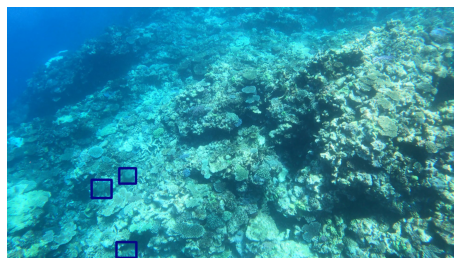

In [25]:
# displays random image and bounding boxes
import random
im_show(random.randint(0,len(yolo_data)-1))

In [26]:
# The images sizes(height,width)
img_size = (720,1280) #h,w

# return the yolo format of the images

def bbox_2_yolo(box):
    xmin = box['x']
    width = box['width']
    ymin = box['y']
    height = box['height']

    xcen = float((2*xmin + width)) / 2 / img_size[1]
    ycen = float((2*ymin + height)) / 2 / img_size[0]

    w = float(width) / img_size[1]
    h = float(height) / img_size[0]

    return 0, xcen, ycen, w, h

In [ ]:
# copy all the images and texts into images and labels folder.
# move the images into the created folders
for(i,image_name) in enumerate(list(yolo_data['filename'])):
    test =False
    annotations = yolo_data.iloc[i]['annotations']
    for box in annotations:
        class_index, xcen, ycen, w, h = bbox_2_yolo(box)
        try:
            split_image = image_name.split('.')[0].split('/')
        except:
            print(image_name)
            print('error')
        if i > 1100:
            if not os.path.exists(TRAIN):
                os.mkdir(TRAIN)
            with open(f'{TRAIN}/labels/{split_image[-2]}_{split_image[-1]}.txt', 'a') as f:
                f.write(f'{class_index} {xcen} {ycen} {w} {h}')
                f.write('\n')
        else:
            test =True
            if not os.path.exists(VALID):
                os.mkdir(VALID)
            with open(f'{VALID}/labels/{split_image[-2]}_{split_image[-1]}.txt', 'a') as f:
                f.write(f'{class_index} {xcen} {ycen} {w} {h}')
                f.write('\n')


    if(test):
        shutil.copy(image_name,f'{VALID}/images/{split_image[-2]}_{split_image[-1]}.jpg')
    else:
        shutil.copy(image_name,f'{TRAIN}/images/{split_image[-2]}_{split_image[-1]}.jpg')

In [ ]:
os.chdir(os.path.join(WORKDIR,'yolov5'))
#WORKDIR/yolov5

In [ ]:
#train the model
!python train.py --img 640 --batch 16 --epochs 30 --data /content/drive/MyDrive/YOLOV5/DATA/data.yaml --weights yolov5s.pt

In [ ]:
!rm -rf {TRAIN} {VALID}